In [1]:
import os 
import matplotlib
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import requests
import re
import datetime
import joblib

from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM
import torch

currentDateTime = datetime.datetime.now()
date = currentDateTime.date()
year = int(date.strftime("%Y"))

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = "#949494"

%matplotlib inline

/home/kurios/Documents/used_car_price/ensembling/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
od.download('https://www.kaggle.com/c/playground-series-s4e9')
os.listdir('playground-series-s4e9')
train = pd.read_csv('playground-series-s4e9/train.csv', low_memory=False)
test = pd.read_csv('playground-series-s4e9/test.csv', low_memory=False)
sub = pd.read_csv('playground-series-s4e9/sample_submission.csv')

Skipping, found downloaded files in "./playground-series-s4e9" (use force=True to force download)


In [3]:
DATASET_DIR = 'playground-series-s4e9/'
DATASET_NAME = 'train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://www.kaggle.com/c/playground-series-s4e9'

In [4]:
N_THREADS = 16
N_FOLDS = 10
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 3600

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [6]:
if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

In [7]:
data = pd.read_csv(DATASET_DIR + DATASET_NAME)

In [20]:
data[data['price'] > 200000]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
43,43,Mercedes-Benz,AMG GT 53 Base,2022,10972,Gasoline,4.0L V8 32V GDI DOHC Twin Turbo,8-Speed Automatic,Magnetite Black Metallic,Black,None reported,Yes,244896
220,220,Ford,F-150 XLT,2021,26315,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Agate Black Metallic,Black,None reported,Yes,2954083
267,267,Aston,Martin Vantage GT Base,2017,127600,Gasoline,430.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,315000
283,283,Tesla,Model Y Performance,2023,7578,NaN,Electric,Automatic,White,Black,None reported,NaN,267950
296,296,Mercedes-Benz,S-Class S 550 4MATIC,2020,44300,Gasoline,449.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,489000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188186,188186,Maserati,Levante Modena,2020,3158,Gasoline,4.0L V8 32V GDI DOHC Twin Turbo,8-Speed Automatic,Verde,Black,None reported,NaN,238900
188192,188192,Porsche,Cayenne Base,2016,87500,Gasoline,300.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,324995
188194,188194,Chevrolet,SSR Base,2004,24915,Gasoline,3.6L V6 24V GDI DOHC,Automatic,Shadow Gray Metallic,Jet Black,None reported,Yes,1950995
188285,188285,Cadillac,CTS 3.6L Premium Luxury,2019,2922,Gasoline,335.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,259000


In [8]:
def convert_engine(val):
    d = {
        'engine_HP': np.nan,
        'engine_L': np.nan,
        'engine_cylinder': np.nan,
        'engine_cylinder_type': np.nan,
        'engine_fuel_type': np.nan,
        'engine_type': np.nan,
        'engine_v': np.nan,
        'engine_vtype': np.nan
    }
    spl = val.replace('-', '').split(' ')
    pos_v1 = -1
    pos_v2 = -1
    for i, v in enumerate(spl):
        if v.endswith('HP'):
            d['engine_HP'] = float(v[:-2])
        elif v.endswith('L'):
            d['engine_L'] = float(v[:-1])
        elif v == 'Engine' and spl[i-1] == 'Cylinder':
            d['engine_cylinder'] = abs(float(spl[i-2].replace('V', '')))
        elif v == 'Fuel':
            d['engine_fuel_type'] = spl[i - 1]
        elif v == 'Liter':
            d['engine_L'] = float(spl[i-1])
        elif v.startswith('V') or v.startswith('H') or v.startswith('I'):
            try:
                d['engine_cylinder'] = float(v[1:])
                d['engine_cylinder_type'] = v[0]
                pos_v1 = i
            except:
                pass
        elif v == 'DOHC' or v == 'OHV':
            d['engine_type'] = ' '.join(spl[i:])
            if pos_v2 != -1:
                d['engine_vtype'] = ' '.join(spl[pos_v2+1:i])
            elif pos_v1 != -1:
                d['engine_vtype'] = ' '.join(spl[pos_v1+1:i])
        elif v.endswith('V'):
            try:
                d['engine_v'] = float(v[:-1])
                pos_v2 = i
            except:
                pass
    return d

def test_params(ModelClass, **params):
    model = ModelClass(**params).fit(X_train, Y_train)
    train_rmse = rmse(model.predict(X_train), Y_train)
    val_rmse = rmse(model.predict(X_val), Y_val)
    return train_rmse, val_rmse


def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    for x,y in zip(param_values,val_errors):
        label = "{:.2f}".format(y)
        plt.annotate(label,
                    (x,y),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])
    plt.show()

In [11]:
average_prices_in_millions = data['model'] ==  'Carrera GT Base'
data[average_prices_in_millions].head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
20128,20128,Porsche,Carrera GT Base,2009,78000,Gasoline,552.0HP 6.0L 12 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Gray,Gray,At least 1 accident or damage reported,Yes,68000
117733,117733,Porsche,Carrera GT Base,2017,22000,Gasoline,605.0HP 5.7L 10 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,229000
126306,126306,Porsche,Carrera GT Base,2005,2950,Gasoline,605.0HP 5.7L 10 Cylinder Engine Gasoline Fuel,6-Speed M/T,Gray,Black,None reported,Yes,1599000
140951,140951,Porsche,Carrera GT Base,2005,66500,Gasoline,315.0HP 3.6L Flat 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Silver,Black,None reported,Yes,27000
144889,144889,Porsche,Carrera GT Base,2008,149000,Gasoline,605.0HP 5.7L 10 Cylinder Engine Gasoline Fuel,6-Speed M/T,Silver,Gray,At least 1 accident or damage reported,Yes,13998


In [14]:
average_prices_in_millions = train['price'] > 200000
train[average_prices_in_millions].head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
43,43,Mercedes-Benz,AMG GT 53 Base,2022,10972,Gasoline,4.0L V8 32V GDI DOHC Twin Turbo,8-Speed Automatic,Magnetite Black Metallic,Black,None reported,Yes,244896
220,220,Ford,F-150 XLT,2021,26315,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Agate Black Metallic,Black,None reported,Yes,2954083
267,267,Aston,Martin Vantage GT Base,2017,127600,Gasoline,430.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,315000
283,283,Tesla,Model Y Performance,2023,7578,NaN,Electric,Automatic,White,Black,None reported,NaN,267950
296,296,Mercedes-Benz,S-Class S 550 4MATIC,2020,44300,Gasoline,449.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,489000


In [9]:
average_prices_by_brand = data.groupby('brand')['price'].mean()

train = data.fillna('dash')
train = train.replace('–', 'dash')

test = test.fillna('dash')
test = test.replace('–', 'dash')

accident_dict = {
    'None reported': 0,
    'At least 1 accident or damage reported': 1,
    'uknown': 2
}

clean_title_dict = {
    'Yes': 0,
    'uknown': 1
}

expensive_ext_color = ['Blue Caelum', 'Dark Sapphire', 'Bianco Monocerus', 'C / C', 'Ice',
       'Tempest', 'Beluga Black', 'Bianco Icarus Metallic', 
       'BLU ELEOS', 'Shadow Black', 'Nero Noctis', 'Sandstone Metallic',
       'Lizard Green', 'Balloon White', 'Onyx', 'Donington Grey Metallic',
       'China Blue', 'Diamond White', 'Rosso Corsa', 'Granite',
       'Rosso Mars Metallic', 'Carpathian Grey', 'Kemora Gray Metallic',
       'Grigio Nimbus', 'dash', 'Bianco Isis', 'Python Green', 'Fountain Blue',
       'Custom Color', 'Vega Blue', 'Designo Magno Matte',
       'Brands Hatch Gray Metallic', 'Rift Metallic', 'Gentian Blue Metallic',
       'Arancio Borealis', 'BLUE', 'Aventurine Green Metallic', 'Apex Blue',
       'Daytona Gray Pearl Effect', 'Daytona Gray Pearl Effect w/ Black Roof',
       'Matte White', 'Carpathian Grey Premium Metallic', 'Blue Metallic',
       'Santorini Black Metallic', 'Quartzite Grey Metallic',
       'Carrara White Metallic', 'BLACK', 'Kinetic Blue', 'Nero Daytona']

expensive_int_color = ['Dark Auburn', 'Hotspur', 'Cobalt Blue', 'Beluga Hide', 'Linen',
                       'Beluga', 'Black / Brown', 'Nero Ade', 'Sahara Tan', 'Portland']

inexpensive_ext_color = ['Gold', 'Frozen White', 'Beige', 'Volcanic Orange',
        'Mountain Air Metallic', 'Crystal Black Pearl', 'Crimson Red Tintcoat',
        'Snowflake White Pearl', 'Sonic Silver Metallic', 'Radiant Red Metallic II',
        'Remington Red Metallic', 'Gecko Pearlcoat', 'Dazzling White',
        'Blue Reflex Mica', 'White Platinum Tri-Coat Metallic', 'Purple',
        'Crystal White Pearl', 'Silver', 'Jet Black Mica', 'Red Quartz Tintcoat']

inexpensive_int_color =['Light Gray', 'Gray', 'Medium Pewter', 'Beige', 'Medium Ash Gray',
       'White / Brown', 'Ash', 'Deep Chestnut', 'Charcoal Black',
       'Whisper Beige', 'Gideon', 'Light Platinum / Jet Black', 'Sand Beige',
       'Mountain Brown', 'Ivory / Ebony', 'Black / Graphite', 'Canberra Beige',
       'Tupelo', 'Charcoal', 'Gold']

low_end_brand = average_prices_by_brand[average_prices_by_brand < 25000].index.tolist()
mid_range_brand = average_prices_by_brand[(average_prices_by_brand > 25000) & (average_prices_by_brand < 40000)].index.tolist()
high_end_brand = average_prices_by_brand[(average_prices_by_brand > 40000) & (average_prices_by_brand < 80000)].index.tolist()
luxury_brand = average_prices_by_brand[average_prices_by_brand > 80000].index.tolist()

def encode_columns(df):
    gases = df.fuel_type.value_counts().index
    for gas in gases:
        df.loc[(df['fuel_type'] == '–') & df['engine'].str.contains(gas), 'fuel_type'] = gas

    milage_per_year = df['milage'] / (year - df['model_year'])

    auto_transmission = df['transmission'].str.contains('A/T') + df['transmission'].str.contains(' At') + df['transmission'].str.contains('Automatic') + df['transmission'].str.contains('Dual Shift') + df['transmission'].str.contains('CVT Transmission') + df['transmission'].str.contains('CVT-F') + df['transmission'].str.contains('Overdrive Switch') + df['transmission'].str.contains('Variable')
    manual_transmission = df['transmission'].str.contains('M/T') + df['transmission'].str.contains(' Mt') + df['transmission'].str.contains('Manual')
    
    df['milage_per_year'] = milage_per_year.astype(int)
    
    df['auto_transmission'] = auto_transmission.astype(int)
    df['manual_transmission'] = manual_transmission.astype(int)

    df['turbo_engine'] = df['engine'].str.contains('Turbo').astype(int)
    df['supercharged_engine'] = df['engine'].str.contains('Supercharged').astype(int)
    df['dohc_engine'] = df['engine'].str.contains('DOHC').astype(int)
    df['ohv_engine'] = df['engine'].str.contains('OHV').astype(int)


    df['low_end_brand'] = df.brand.isin(low_end_brand).astype(int)
    df['mid_range_brand'] = df.brand.isin(mid_range_brand).astype(int)
    df['high_end_brand'] = df.brand.isin(high_end_brand).astype(int)
    df['luxury_brand'] = df.brand.isin(luxury_brand).astype(int)

    df['accident_encoded'] = df['accident'].map(accident_dict)
    df['clean_title_encoded'] = df['clean_title'].map(clean_title_dict)
    df['expensive_color_ext_encoded'] = df.ext_col.isin(expensive_ext_color).astype(int)
    df['expensive_color_int_encoded'] = df.int_col.isin(expensive_int_color).astype(int)
    df['inexpensive_color_ext_encoded'] = df.ext_col.isin(inexpensive_ext_color).astype(int)
    df['inexpensive_color_int_encoded'] = df.int_col.isin(inexpensive_int_color).astype(int)

    df['engine_fuel_type'].replace('dash', np.nan)
    df['engine_fuel_type'] = df.engine_fuel_type.fillna(df['fuel_type'])
    df['engine_fuel_type'] = df.engine_fuel_type.replace('Flexible', 'Flex').replace('E85 Flex Fuel', 'Flex')

    df['engine_HP_per_L'] = df['engine_HP']/df['engine_L']
    
    return df

train = pd.concat([train, pd.DataFrame.from_records(train['engine'].map(convert_engine).values)], axis = 1)
test = pd.concat([test, pd.DataFrame.from_records(test['engine'].map(convert_engine).values)], axis = 1)


train = encode_columns(train)
test = encode_columns(test)

In [10]:
INPUT_COLS = ['model_year', 'milage', 'milage_per_year', 'engine_fuel_type', 
       'low_end_brand', 'mid_range_brand', 'high_end_brand', 'luxury_brand', 
       'turbo_engine', 'dohc_engine', 'supercharged_engine', 'ohv_engine',
       'accident_encoded', 'clean_title_encoded', 'inexpensive_color_int_encoded', 
       'expensive_color_ext_encoded', 'expensive_color_int_encoded', 'inexpensive_color_ext_encoded',
       'auto_transmission', 'manual_transmission', 'engine_HP', 'engine_L', 'engine_HP_per_L',
       'engine_cylinder', 'engine_cylinder_type', 'engine_v', 'engine_vtype']

TARGET_NAME = 'price'

train_df, val_df = train_test_split(train, test_size=TEST_SIZE, stratify=train[TARGET_NAME] ,random_state=RANDOM_STATE)

In [11]:
X_train = train_df[INPUT_COLS].copy()
Y_train = train_df[TARGET_NAME].copy()

X_val = val_df[INPUT_COLS].copy()
Y_val = val_df[TARGET_NAME].copy()

test_inputs = test[INPUT_COLS].copy()

numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes('object').columns.tolist()

In [12]:
imputer = SimpleImputer(strategy='mean').fit(X_train[numeric_cols])

X_train[numeric_cols] = imputer.transform(X_train[numeric_cols])
X_val[numeric_cols] = imputer.transform(X_val[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

scaler = MinMaxScaler().fit(X_train[numeric_cols])

X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(X_train[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

X_train[encoded_cols] = encoder.transform(X_train[categorical_cols])
X_val[encoded_cols] = encoder.transform(X_val[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

train_df = X_train[numeric_cols + encoded_cols]
val_df = X_val[numeric_cols + encoded_cols]
test = test_inputs[numeric_cols + encoded_cols]

train_df['price'] = Y_train
val_df['price'] = Y_val

numeric_cols_df = train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols_df = train_df.select_dtypes('object').columns.tolist()

/tmp/ipykernel_21172/1701471434.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['price'] = Y_train
/tmp/ipykernel_21172/1701471434.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['price'] = Y_val


In [69]:
task = Task('reg')
roles = {
    'target': TARGET_NAME,
}

In [ ]:
automl = TabularAutoML(task = task,
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)
out_of_fold_predictions = automl.fit_predict(train_df, roles = roles, verbose = 1)
joblib.dump(automl, 'lightautoml_3.pkl.pkl')

In [23]:
val_preds = automl.predict(val_df)
print(f'Prediction for val_data:\n{val_preds}\nShape = {val_preds.shape}')
oof_rmse = rmse(train_df[TARGET_NAME].values, out_of_fold_predictions.data)
holdout_rmse = rmse(val_df[TARGET_NAME].values, val_preds.data)

print(f'OOF RMSE: {oof_rmse}')
print(f'HOLDOUT RMSE: {holdout_rmse}')

Prediction for val_data:
array([[38878.875],
       [45248.758],
       [64923.312],
       ...,
       [15983.357],
       [59460.746],
       [45519.434]], dtype=float32)
Shape = (37707, 1)
OOF RMSE: 73533.3671875
HOLDOUT RMSE: 73179.8828125


In [ ]:
val_preds_flat = val_preds.data.flatten()
actual_prices = val_df['price'].values.flatten()

residuals = actual_prices - val_preds_flat
abs_residuals = np.abs(residuals)

print(f"Mean Absolute Error (MAE): {mean_absolute_error(actual_prices, val_preds_flat):,.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(actual_prices, val_preds_flat):,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse(actual_prices, val_preds_flat):,.2f}")
print(f"R-squared (R2): {r2_score(actual_prices, val_preds_flat):.4f}")


Root Mean Squared Error (RMSE): 73,179.88


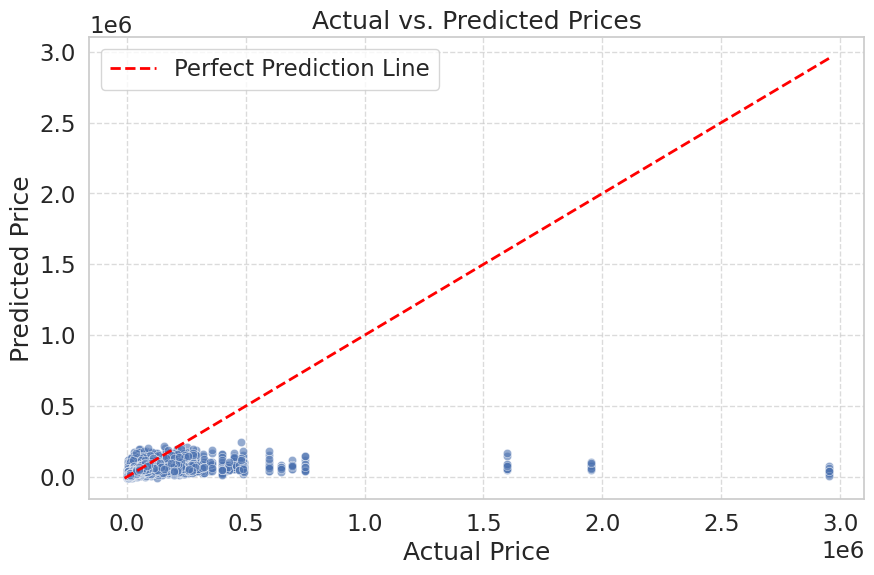

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actual_prices, y=val_preds_flat, alpha=0.6)
min_val = min(actual_prices.min(), val_preds_flat.min())
max_val = max(actual_prices.max(), val_preds_flat.max())
plt.plot([min_val, max_val], [min_val, max_val],
         color='red', linestyle='--', lw=2, label='Perfect Prediction Line')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

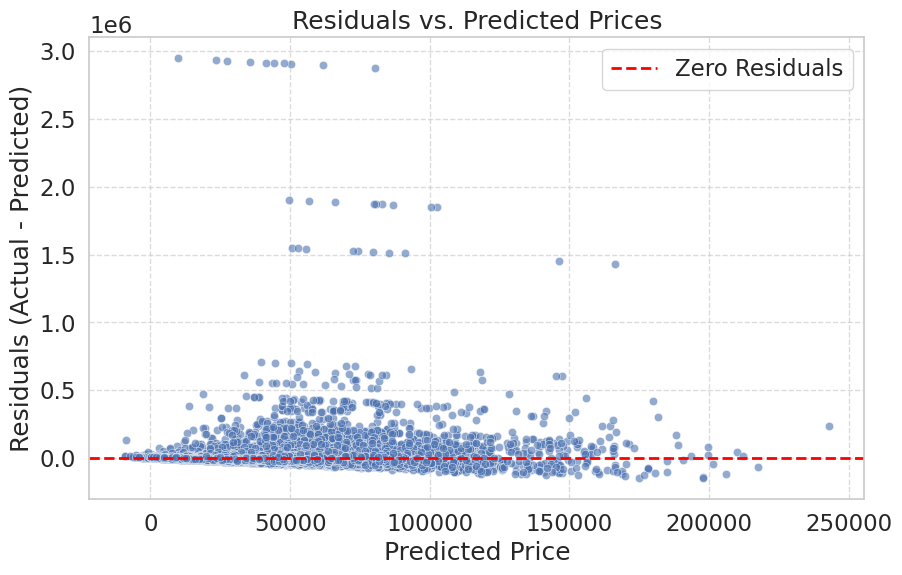

In [56]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=val_preds_flat, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', lw=2, label='Zero Residuals')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted Prices")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

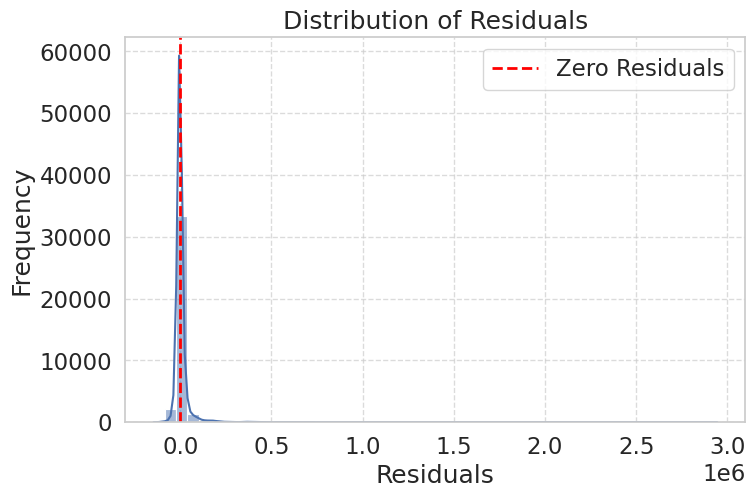

In [57]:
# Plot 3: Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.axvline(x=0, color='red', linestyle='--', lw=2, label='Zero Residuals')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [62]:
val_results = pd.DataFrame({
    'Actual_Price': actual_prices,
    'Predicted_Price': val_preds_flat,
    'Residual': residuals,
    'Abs_Residual': abs_residuals
})
largest_errors = val_results.sort_values(by='Abs_Residual', ascending=False)
print("\nTop 10 samples with largest absolute errors:")
print(largest_errors.head(20))


Top 10 samples with largest absolute errors:
       Actual_Price  Predicted_Price      Residual  Abs_Residual
34179       2954083      9905.054688  2.944178e+06  2.944178e+06
7586        2954083     23529.837891  2.930553e+06  2.930553e+06
13444       2954083     27361.199219  2.926722e+06  2.926722e+06
1156        2954083     35544.929688  2.918538e+06  2.918538e+06
33867       2954083     41473.980469  2.912609e+06  2.912609e+06
37482       2954083     44241.882812  2.909841e+06  2.909841e+06
14027       2954083     47871.480469  2.906212e+06  2.906212e+06
3923        2954083     50379.355469  2.903704e+06  2.903704e+06
25730       2954083     61652.984375  2.892430e+06  2.892430e+06
11200       2954083     80401.929688  2.873681e+06  2.873681e+06
9788        1950995     49468.917969  1.901526e+06  1.901526e+06
26963       1950995     56750.437500  1.894245e+06  1.894245e+06
26116       1950995     65902.257812  1.885093e+06  1.885093e+06
24324       1950995     80015.250000  1.8709

In [21]:
average_prices_by_model = data.groupby('model')['price'].mean()
average_prices_by_model.sort_values(ascending=False)

model
Carrera GT Base                    356937.250000
Gallardo SE                        265551.272727
Phantom Drophead Coupe Drophead    250358.269231
Continental GT GT Speed            244661.833333
Martin DB7 Vantage Volante         229714.312500
                                       ...      
Ram Van 1500                         8693.772727
Eurovan MV                           8245.571429
Yaris L                              8215.625000
Matrix XR                            7688.000000
Integra LS                           7683.117647
Name: price, Length: 1897, dtype: float64